# **20230621**

## 18장 시퀀스 배열로 다루는 순환 신경망(RNN) 계열

- 시퀀스 배열 = 순서가 있는 배열 = 시계열 데이터(주식, 자연어처리,,,)

<br>


- 순환 신경망(Recurrent Neural Network, **RNN**)

    - cell간의 activation function: sigmoid
    
    - **기울기 소실**(gradient vanishing) <- sigmoid에 의해 발생

    - RNN은 위의 문제 때문에 장기 기억 학습은 힘듬 = 단기만 기억 


- **LSTM**(Long Short Term Memory)

    - 과거 학습 데이터 소실 문제가 있는 RNN을 보완한 방법 = 장기기억 가능

    - activation function: sigmoid와 tanh 둘 다 사용

        - sigmoid : 기억 소실용
        - tanh : 기억 보존용

RNN 방식의 다양한 활용

1. 다수 입력 단일 출력 : 문장을 읽고 뜻을 파악할 때 활용(!지도학습!)

2. 단일 입력 다수 출력 : 사진의 캡션을 만들 때 활용

3. 다수 입력 다수 출력 : 문장을 번역할 때 활용

    - seg to seg (시퀀스 to 시퀀스)

### 01 LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [7]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [8]:
# num_words=1000 : 빈도수가 높은 1000개 단어만 가져오기 = 말뭉치(단어사전)
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

In [9]:
category = np.max(y_train) + 1
print(category)
print(len(X_train),'학습용 뉴스 기사')
print(len(X_test),'테스트용 뉴스 기사')
print(X_train[0])

46
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [10]:
# 단어 수 맞추기 : padding

X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

In [11]:
# 답 원-핫 인코딩 : softmax 와 비교 위함
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
model = Sequential()


# Embedding(단어사전, 축소)
model.add(Embedding(1000,100))

# LSTM(패딩된 뉴스 개수(=cell의 개수), activationfunc='tanh')
model.add(LSTM(100, activation='tanh'))

# 출력층
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 185,046
Trainable params: 185,046
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
# 모델 저장x, 테스트만 하고 earlystopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [18]:
history = model.fit(X_train, y_train
                    ,batch_size=20, epochs=200
                    , validation_data=(X_test,y_test)
                    , callbacks=[early_stopping_callback])

Epoch 1/200


450/450 [==============================] - 28s 57ms/step - loss: 2.1818 - accuracy: 0.4477 - val_loss: 1.8658 - val_accuracy: 0.5080
Epoch 2/200
450/450 [==============================] - 31s 69ms/step - loss: 1.7952 - accuracy: 0.5433 - val_loss: 1.7562 - val_accuracy: 0.5668
Epoch 3/200
450/450 [==============================] - 33s 72ms/step - loss: 1.6433 - accuracy: 0.5766 - val_loss: 1.6188 - val_accuracy: 0.5984
Epoch 4/200
450/450 [==============================] - 36s 81ms/step - loss: 1.4784 - accuracy: 0.6256 - val_loss: 1.4652 - val_accuracy: 0.6362
Epoch 5/200
450/450 [==============================] - 32s 71ms/step - loss: 1.3306 - accuracy: 0.6632 - val_loss: 1.3757 - val_accuracy: 0.6545
Epoch 6/200
450/450 [==============================] - 34s 76ms/step - loss: 1.2149 - accuracy: 0.6921 - val_loss: 1.3130 - val_accuracy: 0.6638
Epoch 7/200
450/450 [==============================] - 31s 68ms/step - loss: 1.1174 - accuracy: 0.7180 - val_loss: 1.2183 - val_accuracy: 0.69

In [21]:
print('TEST ACCURACY : %.4f'%(model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 1s 19ms/step - loss: 1.2328 - accuracy: 0.7159
TEST ACCURACY : 0.7159


In [22]:
# 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

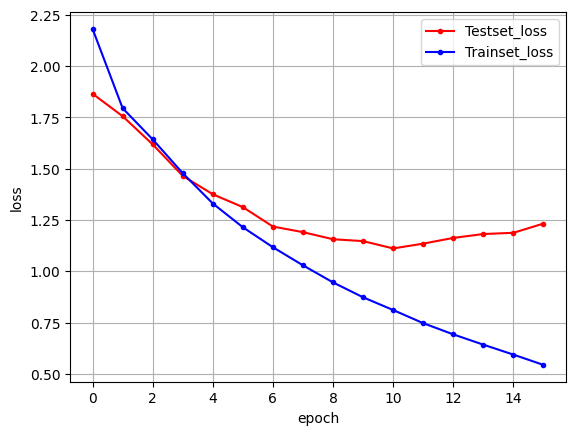

In [24]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red',label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue',label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 02 LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

- countvecterize 되어있음

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping


import numpy as np
import matplotlib.pyplot as plt

In [37]:
(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words=5000)

In [38]:
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

In [39]:
model = Sequential()
model.add(Embedding(5000,100))
# model.add(Dropout(0.5))     # 50% 버림

# 5개 단어씩 특징추출, 1씩 옆으로 이동, => 64개로 분해
model.add(Conv1D(64,5,padding='valid',activation='relu',strides=1))

# 4개씩 묶어서 그 중 가장 큰 특징만 추출
model.add(MaxPooling1D(pool_size=4))

# 특징 55개
model.add(LSTM(55))

# 출력층
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         500000    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 55)                26400     
                                                                 
 dense_2 (Dense)             (None, 1)                 56        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                      

In [40]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [41]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=3)

In [42]:
history = model.fit(X_train, y_train
                    , batch_size=40, epochs=100
                    ,validation_split=0.25, callbacks=[early_stopping_callback])

Epoch 1/100


469/469 [==============================] - 60s 124ms/step - loss: 0.3873 - accuracy: 0.8193 - val_loss: 0.2955 - val_accuracy: 0.8782
Epoch 2/100
469/469 [==============================] - 78s 167ms/step - loss: 0.2183 - accuracy: 0.9162 - val_loss: 0.2587 - val_accuracy: 0.8939
Epoch 3/100
469/469 [==============================] - 60s 128ms/step - loss: 0.1468 - accuracy: 0.9486 - val_loss: 0.2861 - val_accuracy: 0.8899
Epoch 4/100
469/469 [==============================] - 61s 130ms/step - loss: 0.0984 - accuracy: 0.9669 - val_loss: 0.3114 - val_accuracy: 0.8835
Epoch 5/100
469/469 [==============================] - 61s 130ms/step - loss: 0.0637 - accuracy: 0.9807 - val_loss: 0.3844 - val_accuracy: 0.8840


In [43]:
print('Test Accuracy: %.4f'%(model.evaluate(X_test, y_test)[1]))

  1/782 [..............................] - ETA: 32s - loss: 0.5614 - accuracy: 0.8125

782/782 [==============================] - 18s 22ms/step - loss: 0.4146 - accuracy: 0.8738
Test Accuracy: 0.8738


In [44]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

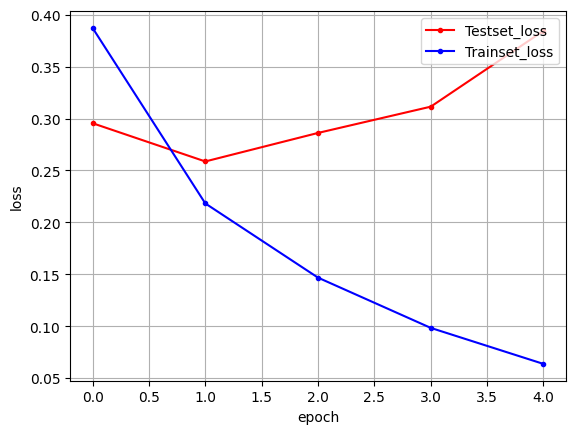

In [45]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red',label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue',label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red',label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue',label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 03 어텐션을 사용한 신경망